In [19]:
import os
from PIL import Image

def convert_ppm_to_jpg(input_dir, output_dir):
    """ Convertir todas las imágenes .ppm en un directorio a .jpg """
    os.makedirs(output_dir, exist_ok=True)
    converted_count = 0
    
    for filename in os.listdir(input_dir):
        if filename.endswith('.ppm'):
            input_path = os.path.join(input_dir, filename)
            output_filename = os.path.splitext(filename)[0] + '.jpg'
            output_path = os.path.join(output_dir, output_filename)
            try:
                with Image.open(input_path) as img:
                    img.convert('RGB').save(output_path, 'JPEG')
                converted_count += 1
            except Exception as e:
                print(f"Error convirtiendo {filename}: {e}")
    
    print(f"Conversión completada. {converted_count} imágenes convertidas.")
    return converted_count

In [20]:
import os
import shutil
from sklearn.model_selection import train_test_split

def organize_dataset(smiles_txt, non_smiles_txt, faces_dir, output_dir, test_size=0.2, val_size=0.2):
    """ Organiza el dataset en carpetas de entrenamiento, validación y prueba."""
    # estructura de carpetas
    for split in ['train', 'validation', 'test']:
        for label in ['smiling', 'not_smiling']:
            os.makedirs(os.path.join(output_dir, split, label), exist_ok=True)
            
    with open(smiles_txt, 'r') as f:
        smiling_images = [line.strip() for line in f.readlines()]
    with open(non_smiles_txt, 'r') as f:
        not_smiling_images = [line.strip() for line in f.readlines()]

    # Dividir en entrenamiento, validación y prueba para ambas clases
    smiling_train, smiling_test = train_test_split(smiling_images, test_size=test_size, random_state=42)
    smiling_train, smiling_val = train_test_split(smiling_train, test_size=val_size, random_state=42)

    not_smiling_train, not_smiling_test = train_test_split(not_smiling_images, test_size=test_size, random_state=42)
    not_smiling_train, not_smiling_val = train_test_split(not_smiling_train, test_size=val_size, random_state=42)

    # Función para mover archivos con manejo de excepciones
    def safe_copy(image_list, source_dir, target_dir, label):
        for image_name in image_list:
            # Limpiar el nombre de la imagen (eliminar espacios)
            image_name = image_name.strip()

            # Construir la ruta completa de origen y destino
            src = os.path.join(source_dir, image_name)
            dst = os.path.join(target_dir, label, image_name)

    # Mover archivos a las carpetas correspondientes
    safe_copy(smiling_train, faces_dir, os.path.join(output_dir, 'train'), 'smiling')
    safe_copy(smiling_val, faces_dir, os.path.join(output_dir, 'validation'), 'smiling')
    safe_copy(smiling_test, faces_dir, os.path.join(output_dir, 'test'), 'smiling')
    safe_copy(not_smiling_train, faces_dir, os.path.join(output_dir, 'train'), 'not_smiling')
    safe_copy(not_smiling_val, faces_dir, os.path.join(output_dir, 'validation'), 'not_smiling')
    safe_copy(not_smiling_test, faces_dir, os.path.join(output_dir, 'test'), 'not_smiling')
    print("Organización completada.")

In [21]:
# Variables
smiles_txt = 'smiles/SMILE_list.txt'
non_smiles_txt = 'smiles/NON-SMILE_list.txt'
faces_dir = 'smiles/faces'
output_dir = './organized_dataset'

organize_dataset(smiles_txt, non_smiles_txt, faces_dir, output_dir)

Organización completada.


In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2DTranspose
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
train_dir = 'organized_dataset/train'
val_dir = 'organized_dataset/validation'
test_dir = 'organized_dataset/test'

# Dimensiones de entrada
IMG_SIZE = (64, 64)

# Generador de datos
datagen = ImageDataGenerator(rescale=1.0/255)

train_data = datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, class_mode='binary', batch_size=32)
val_data = datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, class_mode='binary', batch_size=32)
test_data = datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, class_mode='binary', batch_size=32, shuffle=False)


Found 638 images belonging to 2 classes.
Found 264 images belonging to 2 classes.
Found 154 images belonging to 2 classes.


## Modelo CNN
Entrenamos una CNN tradicional para clasificar imágenes:

In [24]:
def build_cnn(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Salida binaria
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn = build_cnn((64, 64, 3))
cnn.summary()

# Entrenamiento
cnn.fit(train_data, validation_data=val_data, epochs=10)

# Evaluación
loss, accuracy = cnn.evaluate(test_data)
print(f"Precisión en el conjunto de prueba: {accuracy:.2f}")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,329 (2.61 MB)

 Trainable params: 683,329 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4701 - loss: 0.7250 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5335 - loss: 0.7000 - val_accuracy: 0.3636 - val_loss: 0.7780
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5735 - loss: 0.6695 - val_accuracy: 0.3636 - val_loss: 0.7212
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6987 - loss: 0.5196 - val_accuracy: 0.9129 - val_loss: 0.3753
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8644 - loss: 0.3650 - val_accuracy: 0.9394 - val_loss: 0.2526
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8755 - loss: 0.2953 - val_accuracy: 0.9053 - val_loss: 0.2697
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9177 - loss: 0.2117 - val_accuracy: 0.9583 - val_loss: 0.2117
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9379 - loss: 0.2071 - val_accuracy: 0.9508 - val_loss: 0.1404
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9485 - loss: 0.1688 - val_accuracy: 0.9583 - val_loss: 0.

## Modelo Autoencoder
El autoencoder se entrenará solo con imágenes de una clase (por ejemplo, "sonriente"):

In [25]:
def build_autoencoder(input_shape):
    # Encoder
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)  # Añadir dropout después de la primera capa
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(encoded)  # Añadir dropout antes del decoder
    
    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.25)(x)  # Añadir dropout en el decoder
    x = Conv2DTranspose(32, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)
    x = Dropout(0.25)(x)  # Añadir otro dropout en el decoder
    decoded = Conv2DTranspose(3, (3, 3), activation='sigmoid', strides=(2, 2), padding='same')(x)
    
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

autoencoder = build_autoencoder((64, 64, 3))
autoencoder.summary()

train_data.reset()
val_data.reset()
test_data.reset()

def extract_images_by_class(generator, target_class=1):
    images = []
    labels = []
    generator.reset()
    
    for _ in range(len(generator)):
        x_batch, y_batch = generator.__next__()
        mask = (y_batch == target_class)
        if np.any(mask):
            images.append(x_batch[mask])
            labels.append(y_batch[mask])
    if images:
        images = np.concatenate(images)
        labels = np.concatenate(labels)
    return images

smiling_images = extract_images_by_class(train_data, target_class=1)

# Entrenar el autoencoder
autoencoder.fit(
    smiling_images, #Input data
    smiling_images, # Etiquetas (mismos datos para autoencoder)
    epochs=10, 
    validation_data=(
        extract_images_by_class(val_data, target_class=1),
        extract_images_by_class(val_data, target_class=1)))

test_images = extract_images_by_class(test_data, target_class=1)

# Evaluación del error de reconstrucción
reconstructions = autoencoder.predict(test_images)
errors = np.mean(np.square(reconstructions - test_images), axis=(1, 2, 3))
threshold = np.percentile(errors, 95)  # Umbral para clasificar anomalías
predictions = autoencoder.predict(test_data, batch_size=32)
predictions = (predictions > 0.5).astype(int)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0409 - val_loss: 0.0347
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0352 - val_loss: 0.0335
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0317 - val_loss: 0.0333
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0303 - val_loss: 0.0335
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0290 - val_loss: 0.0337
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0229 - val_loss: 0.0361
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0173 - val_loss: 0.0373
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0138 - val_loss: 0.0400
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0108 - val_loss: 0.0416
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0092 - val_loss: 0.0422
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [26]:
predictions_flat = predictions.reshape(predictions.shape[0], -1) 
predictions_binary = (predictions_flat.mean(axis=1) > 0.5).astype(int)  # Convertir a binario

In [27]:
predictions_binary = predictions_binary[:len(test_data.classes)]  

## Comparación y Métricas


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Métricas CNN:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88        33
           1       0.97      0.96      0.97       121

    accuracy                           0.95       154
   macro avg       0.92      0.93      0.92       154
weighted avg       0.95      0.95      0.95       154



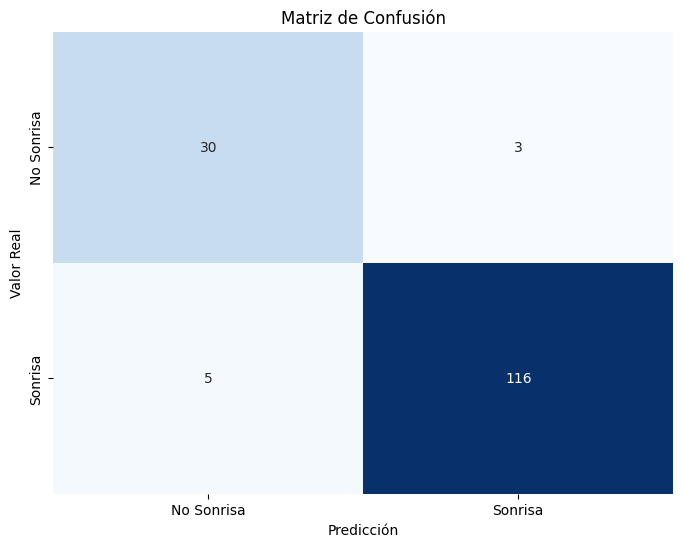

Métricas Autoencoder:
              precision    recall  f1-score   support

           0       0.24      0.67      0.36        33
           1       0.83      0.44      0.57       121

    accuracy                           0.49       154
   macro avg       0.54      0.55      0.47       154
weighted avg       0.70      0.49      0.53       154



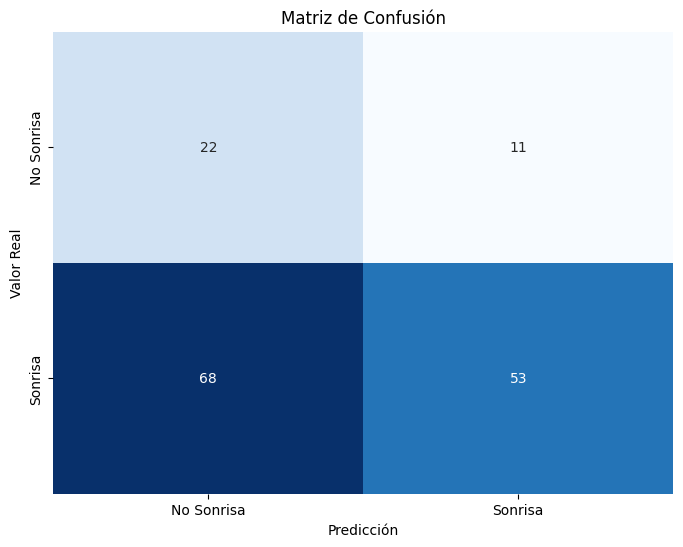

In [29]:
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=False)
    plt.title("Matriz de Confusión")
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.show()

# Predicciones de la CNN
cnn_predictions = (cnn.predict(test_data) > 0.5).astype(int)

# CNN
print("Métricas CNN:")
print(classification_report(test_data.classes, cnn_predictions))
cm_cnn = confusion_matrix(test_data.classes, cnn_predictions)
plot_confusion_matrix(cm_cnn, labels=["No Sonrisa", "Sonrisa"])

# Autoencoder (usando las predicciones binarias)
print("Métricas Autoencoder:")
print(classification_report(test_data.classes, predictions_binary))  # Usamos 'predictions_binary' como las predicciones binarizadas
cm_autoencoder = confusion_matrix(test_data.classes, predictions_binary)
plot_confusion_matrix(cm_autoencoder, labels=["No Sonrisa", "Sonrisa"])
